In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np


In [2]:
# window
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 내 장치가 GPU 인지 CPU 인지 확인

# mac
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu') # 내 장치가 GPU 인지 CPU 인지 확인

print(f"지금 실행중인 하드웨어 장치 : {device}")

lr = 0.001
num_epochs = 10

지금 실행중인 하드웨어 장치 : mps


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
])

In [4]:
# root 위치에 train dataset을 저장해라. 불러올때 transform을 적용해서 불러와라
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

# root 위치에 test dataset을 저장해라. 불러올때 transform을 적용해서 불러와라
test_datset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_datset, batch_size=128, shuffle=False, num_workers=4)


In [6]:
class AutoEncoder(nn.Module):
	def __init__(self):
		super(AutoEncoder, self).__init__()
		self.encoder = nn.Sequential( # 여러개의 층을 쌓을 때는 nn.Sequential을 사용한다.
			nn.Linear(784, 128),
			nn.ReLU(),
			nn.Linear(128, 64),
			nn.ReLU(),
			nn.Linear(64, 32),
		)
		self.decoder = nn.Sequential(
			nn.Linear(32, 64),
			nn.ReLU(),
			nn.Linear(64, 128),
			nn.ReLU(),
			nn.Linear(128, 784),
		)

	def forward(self, x):
		x = x.view(x.size(0), -1)  # Flatten the input
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded, encoded

In [33]:
model = AutoEncoder().to(device)  # 모델을 장치에 할당
criterion = nn.MSELoss()  # Mean Squared Error Loss
optim = torch.optim.Adam(model.parameters(), lr=lr)
model.train()  # 모델을 학습 모드로 설정
# 모델 학습
for epoch in range(num_epochs):
    run_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.view(inputs.size(0), -1)  # 이미지를 1차원 벡터로 변환
        inputs = inputs.to(device)  # 입력 데이터를 장치에 할당
        
        optim.zero_grad() # 기울기 초기화
        
		# forward
        decoded, encoded = model(inputs)
        loss = criterion(decoded, inputs)
        
		# backward
        loss.backward()
        optim.step()
        
		# accumulate loss
        run_loss += loss.item()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {run_loss/len(train_loader):.4f}')


Epoch [1/10], Loss: 0.1627
Epoch [2/10], Loss: 0.0967
Epoch [3/10], Loss: 0.0829
Epoch [4/10], Loss: 0.0755
Epoch [5/10], Loss: 0.0713
Epoch [6/10], Loss: 0.0677
Epoch [7/10], Loss: 0.0654
Epoch [8/10], Loss: 0.0635
Epoch [9/10], Loss: 0.0618
Epoch [10/10], Loss: 0.0605


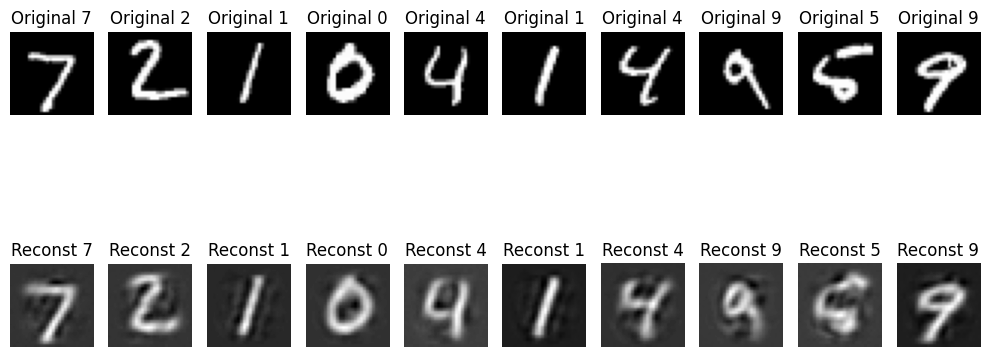

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# 이미지를 1차원 벡터로 변환
images_flat = images.view(images.size(0), -1).to(device)

model.eval()  # 모델을 평가 모드로 설정

reconstructed_images_flat, encoded = model(images_flat)
reconstructed_images = reconstructed_images_flat.view(images.size())

n_image = 10
plt.figure(figsize=(10, 6))

for i in range(n_image):
	plt.subplot(2, n_image, i + 1)
	plt.imshow(np.transpose(images[i].numpy(), (1,2,0)).squeeze(), cmap='gray')
	plt.axis('off')
	plt.title(f'Original {labels[i].item()}')

	plt.subplot(2, n_image, i + 1 + n_image)
	plt.imshow(np.transpose(reconstructed_images[i].detach().cpu().numpy(), (1,2,0)).squeeze(), cmap='gray')
	# plt.imshow(reconstructed_images[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
	plt.axis('off')
	plt.title(f'Reconst {labels[i].item()}')

plt.tight_layout()
plt.show()

In [ ]:
# Encoder : (28x28x1 --> 28x28x16 --> 14x14x16 --> 14x14x32 --> 7x7x32)
# Decoder : (7x7x32 -->14x14x32 --> 28x28x16 --> 28x28x1)
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1,16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16,32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) # --> 7x7x32

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)

      return decoded, encoded

Epoch [1/10], Loss: 0.9265
Epoch [2/10], Loss: 0.8546
Epoch [3/10], Loss: 0.8486
Epoch [4/10], Loss: 0.8411
Epoch [5/10], Loss: 0.8401
Epoch [6/10], Loss: 0.8395
Epoch [7/10], Loss: 0.8390
Epoch [8/10], Loss: 0.8387
Epoch [9/10], Loss: 0.8384
Epoch [10/10], Loss: 0.8382


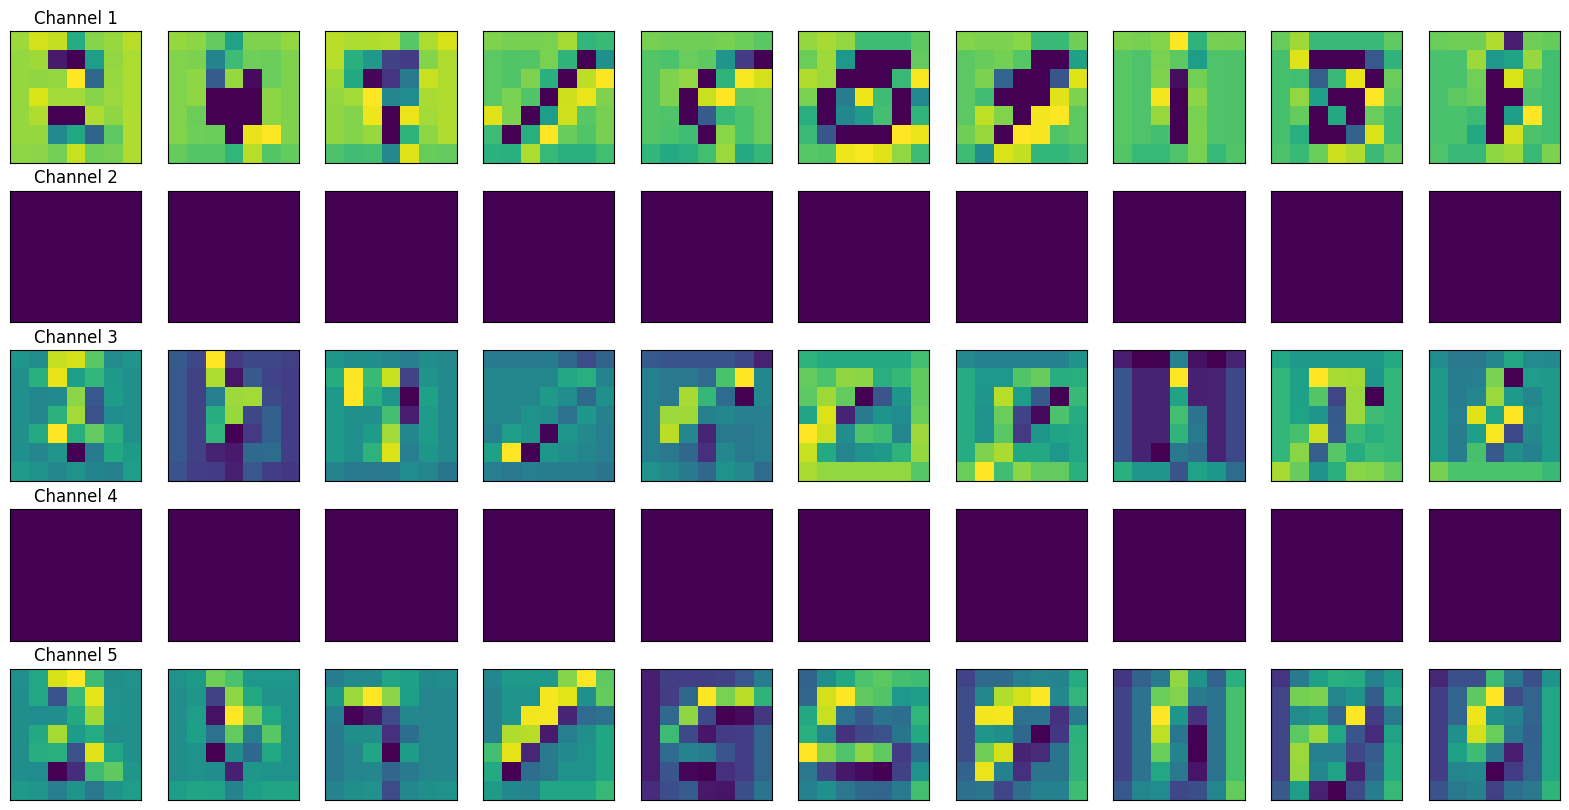

In [20]:
model = CNNAutoencoder()  # 모델을 장치에 할당
criterion = nn.MSELoss() # Mean Squared Error loss for autoencoders
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training loop
num_epochs = 10
num_channels_to_show = 5

plt.figure(figsize=(20, 10))

for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    running_loss = 0.0
    for data in train_loader:
        inputs, _ = data # Autoencoder input is the image itself, ignore the label
        optimizer.zero_grad() # Zero the parameter gradients

        outputs, encoded_feat = model(inputs) # Forward pass

        loss = criterion(outputs, inputs) # Calculate the loss

        loss.backward() # Backward pass
        optimizer.step() # Optimize

        running_loss += loss.item()

    for c in range(num_channels_to_show):
        ax = plt.subplot(num_channels_to_show, num_epochs, epoch + c * num_epochs+1) # Adjust subplot position for multiple channels
        encoded_img_channel = encoded_feat[epoch, c, :, :].detach().cpu().numpy()
        plt.imshow(encoded_img_channel, cmap='viridis') # Use a different colormap for feature maps
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if epoch == 0 and c >=0:
            ax.set_title(f"Channel {c+1}")

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')
    if epoch == num_epochs:
        print('Finished Training')
        # You can optionally save the trained model
        # torch.save(model.state_dict(), 'cnn_autoencoder.pth')

plt.show()

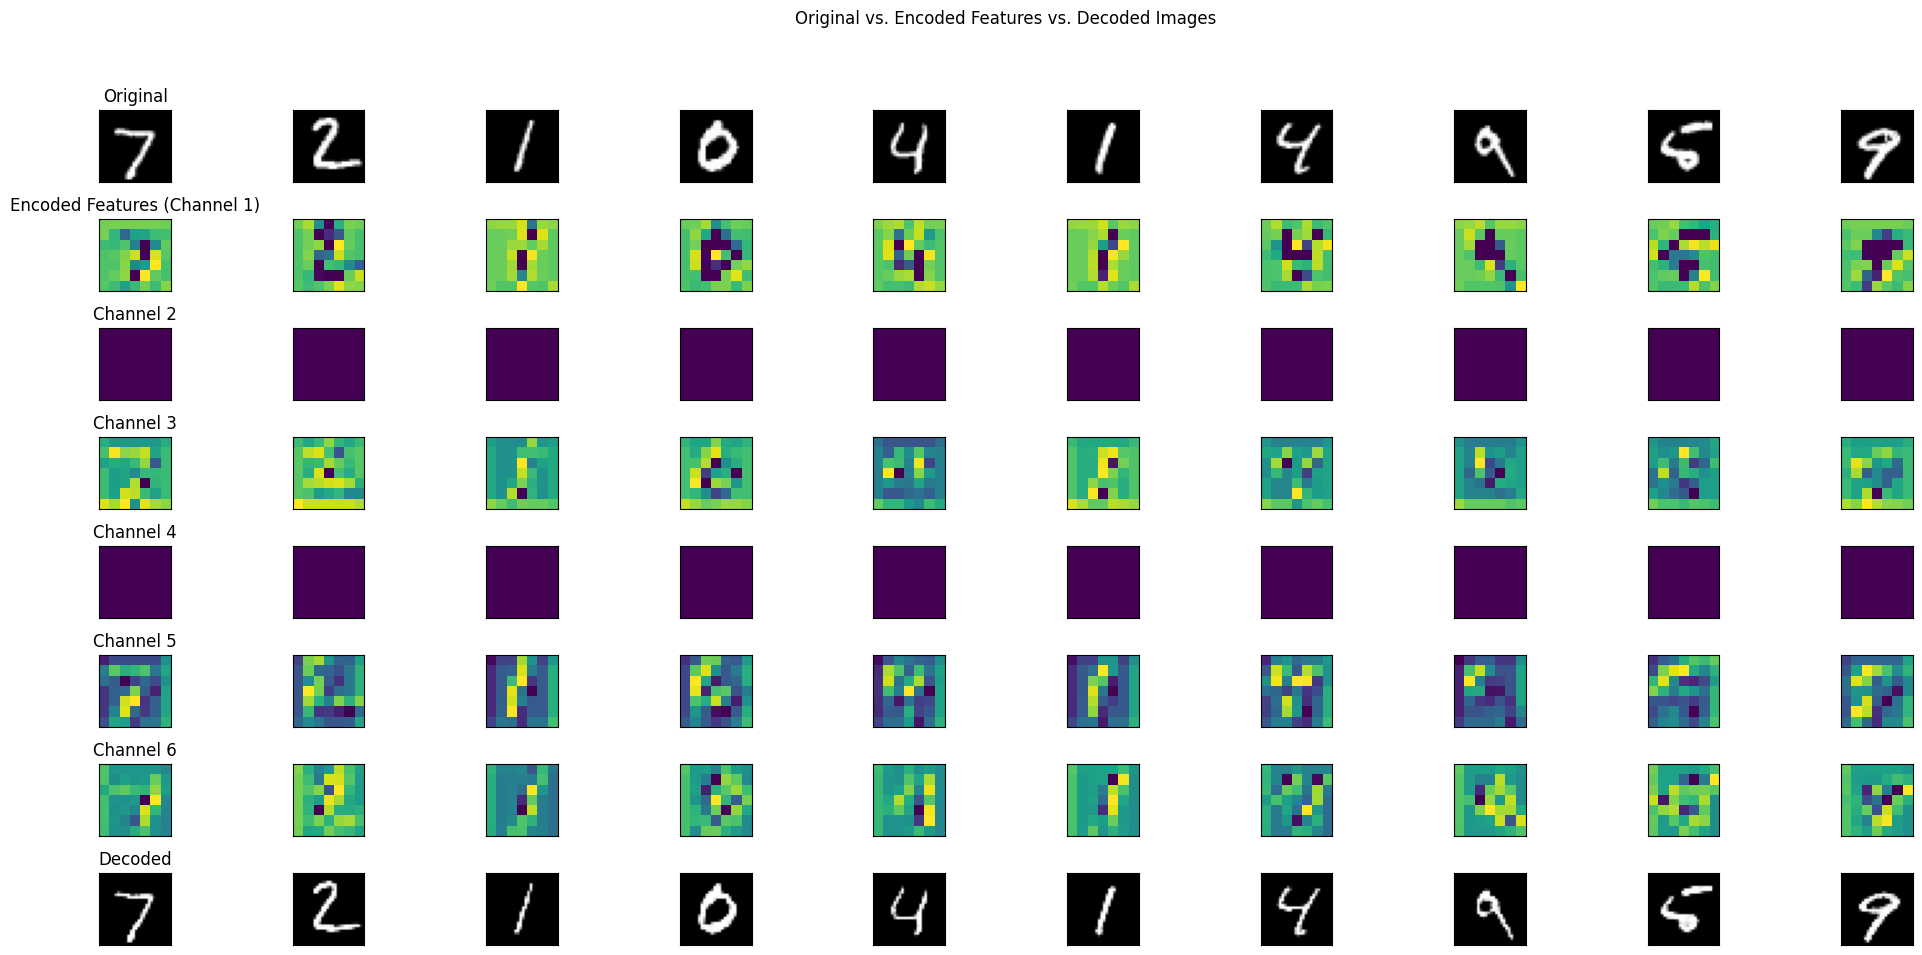


Shapes of Intermediate Tensors:
Input Image Batch Shape: torch.Size([128, 1, 28, 28])
Encoded Feature Batch Shape: torch.Size([128, 32, 7, 7])
Decoded Image Batch Shape: torch.Size([128, 1, 28, 28])


In [21]:
# Evaluation and Intermediate Result Visualization

model.eval() # Set the model to evaluation mode
with torch.no_grad(): # No need to calculate gradients
    # Get a batch of test data
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Forward pass through the autoencoder
    decoded_images, encoded_features = model(images)

    # Compare original images, encoded representations, and decoded images
    n = 10  # Number of images to display
    num_channels_to_show = 6 # You can adjust this

    plt.figure(figsize=(20, 10))
    for i in range(n):
        # Original Images
        ax = plt.subplot(num_channels_to_show+2, n, i + 1)
        # Unnormalize the image for display (reverse the normalization done during preprocessing)
        img = images[i].cpu().numpy() * 0.5 + 0.5
        plt.imshow(np.transpose(img.squeeze(), (0, 1)), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title("Original")

        # Intermediate Encoded Feature Maps (Example of visualizing the output of the last encoder layer)
        # Select a few channels from the encoded features to visualize

        for c in range(num_channels_to_show):
            ax = plt.subplot(num_channels_to_show+2, n, n + i + c * n+1) # Adjust subplot position for multiple channels
            encoded_img_channel = encoded_features[i, c, :, :].cpu().numpy()
            plt.imshow(encoded_img_channel, cmap='viridis') # Use a different colormap for feature maps
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == 0 and c == 0:
                 ax.set_title("Encoded Features (Channel 1)") # Label for the first channel
            elif i == 0 and c > 0:
                 ax.set_title(f"Channel {c+1}")


        # Decoded Images
        ax = plt.subplot(num_channels_to_show+2, n, (num_channels_to_show+1) * n + i + 1)
        # The decoder outputs values between 0 and 1 due to the Sigmoid activation
        decoded_img = decoded_images[i].cpu().numpy().squeeze()
        plt.imshow(decoded_img, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title("Decoded")

    plt.suptitle("Original vs. Encoded Features vs. Decoded Images")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()


    # Example of printing shapes of intermediate tensors (for debugging/understanding)
    print("\nShapes of Intermediate Tensors:")
    print(f"Input Image Batch Shape: {images.shape}") # Should be [batch_size, 1, 28, 28]
    print(f"Encoded Feature Batch Shape: {encoded_features.shape}") # Should be [batch_size, 32, 7, 7]
    print(f"Decoded Image Batch Shape: {decoded_images.shape}") # Should be [batch_size, 1, 28, 28]
